In [1]:
import os
import json
import time

import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from distributed import Client

# print coffea version
import coffea
print(f"coffea version:")
print(coffea.__version__)

client = Client()

# creates directory if it does not exist
def makeDir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        h_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{\mu\mu}$ [GeV]")
            .Int64()
        )

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="same", mass=dimuon.mass)

        return {
            dataset: {
                "entries": ak.num(events, axis=0),
                "mass": h_mass,
            }
        }

    def postprocess(self, accumulator):
        pass

/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


coffea version:
2024.10.0


If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of `uproot.lazy`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators


In [2]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema

start_time = time.time()

#filename = "file://Run2012B_DoubleMuParked.root"
filename = "/eos/user/c/caleb/CMS/datasets/2023_Data/Muon0_Run2023C-22Sep2023_v1-v1_NANOAOD/01e84393-6b2e-4d57-87a4-f71475c051a2.root"
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    steps_per_file=1,
    metadata={"dataset": "Muon_Data"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
output_1 = p.process(events)
(computed_1,) = dask.compute(output_1)

end_time = time.time()

run_time = end_time - start_time

print("computed_1:")
print(computed_1)
print("run time: {0:.2f} seconds".format(run_time))

/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/factory.py:317: RuntimeWarning: You have set steps_per_file to 1, this should only be used for a
                small number of inputs (e.g. for early-stage/exploratory analysis) since it does not
                inform dask of each chunk lengths at creation time, which can cause unexpected
                slowdowns at scale. If you would like to process larger datasets please specify steps
                using the appropriate uproot "files" specification:
                    https://github.com/scikit-hep/uproot5/blob/v5.1.2/src/uproot/_dask.py#L109-L132.
                
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get sta

computed_1:
{'Muon_Data': {'entries': 1032791, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 316069.0 (319246.0 with flow)}}
run time: 12.71 seconds


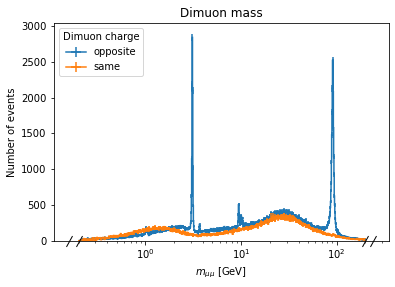

In [3]:
import matplotlib.pyplot as plt

# create directory for plots
plot_dir  = "plots"
makeDir(plot_dir)

# create plot
fig, ax = plt.subplots()
computed_1["Muon_Data"]["mass"].plot1d(ax=ax)
ax.set_title("Dimuon mass")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dimuon charge")

# save plot to png and pdf files
plot_name = "dimuon_mass_one_file"
output_png = "plots/{0}.png".format(plot_name)
output_pdf = "plots/{0}.pdf".format(plot_name)
plt.savefig(output_png, bbox_inches='tight')
plt.savefig(output_pdf, bbox_inches='tight')

One could expand on this code to run over several chunks of the file, setting `entry_start` and `entry_stop` as appropriate. Then, several datasets could be processed by iterating over several files. However, the `dask.compute` and `coffea.dataset_tools` can help with this! We can `preprocess` multiple files and then use our custom `MyProcessor` class to generate the relevant dask task graph. Finally, the result can be obtained by calling `dask.compute`. Since these files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [4]:
# fileset = {
#     "sample_1": {
#         "files": {
#             "file_1.root": "Events",
#             "file_2.root": "Events"
#         }
#     },
#     "sample_2": {
#         "files": {
#             "file_1": "Events",
#             "file_2": "Events"
#         }
#     }
# }

# load fileset from json file
fileset = None
with open("../json/2023_Data/Muon0_Run2023C-22Sep2023_v1-v1_NANOAOD.json", "r") as my_file:
    fileset = json.load(my_file)

dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=1_000_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [5]:
start_time = time.time()

to_compute = apply_to_fileset(
                MyProcessor(),
                max_chunks(dataset_runnable, 300),
                schemaclass=BaseSchema,
            )
(output_2,) = dask.compute(to_compute)

end_time = time.time()

run_time = end_time - start_time

print("output_2:")
print(output_2)
print("run time: {0:.2f} seconds".format(run_time))

output_2:
{'Muon_Data': {'Muon_Data': {'entries': 54715896, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 16165760.0 (16334984.0 with flow)}}}
run time: 285.82 seconds


The run may depend on how many cores are available on the machine you are running this notebook and your connection to `eospublic.cern.ch`.

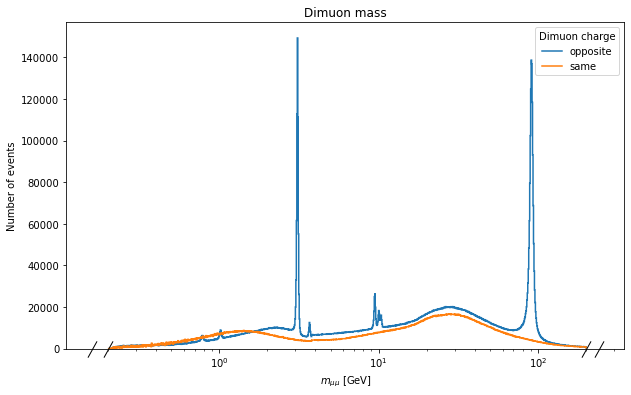

In [6]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))
output_2["Muon_Data"]["Muon_Data"]["mass"].plot1d(ax=ax)
ax.set_title("Dimuon mass")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dimuon charge")

# save plot to png and pdf files
plot_name = "dimuon_mass_all_files"
output_png = "plots/{0}.png".format(plot_name)
output_pdf = "plots/{0}.pdf".format(plot_name)
plt.savefig(output_png, bbox_inches='tight')
plt.savefig(output_pdf, bbox_inches='tight')